In [2]:
%load_ext autoreload
%autoreload 2

import os 
# os.environ['R_HOME']= r'C:\Users\tomha\miniconda3\envs\octagon_analysis\lib\R'
os.environ['R_HOME']=r'D:\Users\Tom\miniconda3\envs\octagon_analysis\lib\R'
# os.environ['R_HOME']= '/home/tom/miniconda3/envs/octagon_analysis/lib/R'


import rpy2

import rpy2.robjects as robjects
print(robjects.r('R.version.string'))

import parse_data.prepare_data as prepare_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import globals
import data_strings
import data_extraction.get_indices as get_indices
import analysis.wall_visibility_and_choice as wall_visibility_and_choice
from trajectory_analysis import trajectory_vectors
from plotting import plot_octagon
import parse_data.identify_filepaths as identify_filepaths 
from data_extraction.trial_list_filters import filter_trials_other_visible
from analysis import opponent_visibility
from ipywidgets import IntProgress
from IPython.display import display
import time

# max_count = 100

# f = IntProgress(min=0, max=max_count) # instantiate the bar
# display(f) # display the bar

# count = 0
# while count <= max_count:
#     f.value += 1 # signal to increment the progress bar
#     time.sleep(.1)
#     count += 1


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[1] "R version 4.1.3 (2022-03-10)"



### Create a dataframe to feed into a GLM using D2H, D2L, First Seen, Wall Separation, and PlayerID (random effect) to predict P(Choose High)

In [3]:
data_folder = data_strings.DATA_FOLDER
json_filenames_social, json_filenames_solo = identify_filepaths.get_filenames()

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/mnt/tom/ceph/ogma/human_octagon/RAW/standard'

In [3]:
# # restrict data for testing
# json_filenames_social = json_filenames_social[:8]
# json_filenames_solo = json_filenames_solo[:32]

In [3]:
df, trial_lists_social = prepare_data.prepare_data(data_folder, json_filenames_social, combine=False)

IntProgress(value=0, max=37)

filepath: /mnt/tom/ceph/ogma/human_octagon/RAW/standard/250401_1/2025-04-01_14-27-01_IS01_HQ01_Social.json
Loading complete.
Preprocessing complete.
filepath: /mnt/tom/ceph/ogma/human_octagon/RAW/standard/250314_3/2025-03-14_14-24-05_MA14_RM14_Social.json
Loading complete.
Preprocessing complete.
filepath: /mnt/tom/ceph/ogma/human_octagon/RAW/standard/250411_1/2025-04-11_09-29-35_IN11_CW11_Social.json
Loading complete.
Preprocessing complete.
filepath: /mnt/tom/ceph/ogma/human_octagon/RAW/standard/241112_1/2024-11-12_13-31-14_KA12_WM12_Social.json
Loading complete.
Preprocessing complete.
filepath: /mnt/tom/ceph/ogma/human_octagon/RAW/standard/250318_3/2025-03-18_17-27-32_HM18_SC18_Social.json
Loading complete.
Preprocessing complete.
filepath: /mnt/tom/ceph/ogma/human_octagon/RAW/standard/241203_1/2024-12-03_14-31-51_PO03_NN03_Social.json
Loading complete.
Preprocessing complete.
filepath: /mnt/tom/ceph/ogma/human_octagon/RAW/standard/250421_1/2025-04-21_09-29-53_NM21_KC21_Social.json

In [5]:
df, trial_lists_solo = prepare_data.prepare_data(data_folder, json_filenames_solo, combine=False)

IntProgress(value=0, max=148)

filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\pseudonymised_json_files\240913_1\2024-09-13_11-23-37_YW13_FirstSolo.json
Data is from period before 2024-09-13 00:00:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\pseudonymised_json_files\240913_1\2024-09-13_11-53-34_YW13_SecondSolo.json
Data is from period before 2024-09-13 00:00:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\pseudonymised_json_files\240913_1\2024-09-13_11-23-50_JL13_FirstSolo.json
Data is from period before 2024-09-13 00:00:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\pseudonymised_json_files\240913_1\2024-09-13_11-53-56_JL13_SecondSolo.json
Data is from period before 2024-09-13 00:00:00
Running 

In [6]:
# create a list of combined pre- and post- social solo sessions, removing 5 trials from each pre
trial_lists_combined_solo = []
cut_trials = 5
for i in range(0,len(trial_lists_solo), 2): # iterate over each individual
    # get the trial lists for both solo sessions
    trial_list_first_solo = trial_lists_solo[i]
    trial_list_second_solo = trial_lists_solo[i + 1]

    # cut first cut_trials trials (learning controls/associations) from the first solo
    trial_list_first_solo = trial_list_first_solo[cut_trials:]

    # combine trial lists from the first and second solo sessions (the current and consecutive index)
    trial_list = trial_list_first_solo + trial_list_second_solo

    trial_lists_combined_solo.append(trial_list)


In [7]:
len(trial_lists_combined_solo), len(trial_lists_social)

(74, 37)

### Regressor value extraction functions (for one session)

In [8]:
def extract_wall_sep(trial_list):
    ''' Return wall separation for one session.
        1 for 45 degrees, 2 for 90 and 4 for 180. '''
    
    wall_sep = np.full(len(trial_list), np.nan)
    for i, trial in enumerate(trial_list):
        wall_sep_this_trial = get_indices.get_wall_difference(trial=trial)
        wall_sep[i] = wall_sep_this_trial

    return wall_sep


def extract_first_wall_seen(trial_list, player_id):
    ''' Return first visible walls for one player across one session.
        1 for WALL_1, 2 for WALL_2, np.nan for no visible wall (or both initially visible). '''
        
    high_wall_first_visible_session = wall_visibility_and_choice.get_given_wall_first_visible_session(trial_list,
                                                                                                        player_id,
                                                                                                        wall_index=0,
                                                                                                        current_fov=110)

    low_wall_first_visible_session = wall_visibility_and_choice.get_given_wall_first_visible_session(trial_list,
                                                                                                        player_id, 
                                                                                                        wall_index=1,
                                                                                                        current_fov=110)
    low_wall_first_visible_session = low_wall_first_visible_session*2
    
    first_visible_session = high_wall_first_visible_session + low_wall_first_visible_session

    first_visible_session[first_visible_session == 0] = np.nan

    return first_visible_session

def extract_first_wall_visibilities(trial_list, player_id):
    ''' Return first visible walls for one player across one session.
        1 for WALL_1, 2 for WALL_2, 3 for WALL_1 and WALL_2 initially visible, and np.nan for no visible wall. '''

    first_visible_session = np.full(len(trial_list), np.nan)
    for i, trial in enumerate(trial_list):
        wall_vis_order = wall_visibility_and_choice.get_wall_visibility_order_trial(player_id, trial, current_fov=110)

        # decide whether one wall is first visible, both were initially visible, or neither wall was visible
        # plus 1 to each index to match the wall number (1 and 2) rather than the index (0 and 1)
        if np.all(wall_vis_order == 0): # both walls visible at the start of the trial
            # this_trial_first_visible = wall_vis_order.size + 1
            this_trial_first_visible = np.nan  # optionally set both walls visible to np.nan instead of 3
        elif np.all(np.isnan(wall_vis_order)): # neither wall visible at the start of the trial
            this_trial_first_visible = np.nan
        elif np.sum(wall_vis_order == 0) == 1: # one wall visible at the start of the trial
            this_trial_first_visible = np.where(wall_vis_order == 0)[0][0] + 1

        first_visible_session[i] = this_trial_first_visible

    return first_visible_session

# double check code
def extract_distances_to_walls(trial_list, player_id, normalise=False):
    ''' Return a trial_num, 2 sized array, where column 1
        is distance to WALL_1, and column 2 is distance to WALL_2.
        Data applies to one full session, and specified player_id.
        If normalise, returns distances as a proportion of the maximum
        possible in the arena '''
    
    # get octagon alcove coordinates
    alcove_coordinates = plot_octagon.return_alcove_centre_points()

    positions_session = np.full((len(trial_list), 2), np.nan)
    walls_session = np.full((len(trial_list), 2), np.nan)
    distances_session = np.full((len(trial_list), 2), np.nan)

    # get distances for each trial in the session
    for i, trial in enumerate(trial_list):
        # get WALL_1 and WALL_2 coordinates
        trial_walls = get_indices.get_walls(trial)
        high_wall_idx = trial_walls[0] - 1
        low_wall_idx = trial_walls[1] - 1
        trial_high_coordinates = alcove_coordinates[:,high_wall_idx]
        trial_low_coordinates = alcove_coordinates[:, low_wall_idx]

        # index trajectory at timepoint 0 to get player starting coordinates
        trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=trial, player_id=player_id)
        trial_start_position = trajectory[:,0]

        # find distance between start position and WALL_1/WALL_2
        d2h = np.linalg.norm(trial_high_coordinates - trial_start_position) # WALL_1
        d2l = np.linalg.norm(trial_low_coordinates - trial_start_position) # WALL_2

        walls_session[i,:] = trial_walls 
        positions_session[i,:] = trial_start_position
        distances_session[i,:] = np.hstack((d2h, d2l))

    # normalise to maximum possible distance in octagon
    if normalise:
        distances_session = distances_session/plot_octagon.return_maximum_distance()

    return distances_session


def extract_opponent_visibility_slice_onset(trial_list, player_id, current_fov=110):
    ''' Return opponent visibility at slice onset for one player for one session.
        1 for opponent visible, 0 for opponent not visible '''
    
    # slice onset angle of Other from self centre FoV
    orientation_angle_to_other_session = opponent_visibility.get_angle_of_opponent_from_player_session(player_id, trial_list)

    # boolean array of Other visible
    other_visible_session = opponent_visibility.get_other_visible_session(orientation_angle_to_other_session, current_fov)
    other_visible_session = other_visible_session.astype(int) # converted to int for categorical regressor

    # does this return 1 and 0? 

    return other_visible_session


def extract_player_choice(trial_list, player_id, inferred_choice=True, debug=True):
    ''' Return (inferred by default) player choice for one player for one session.
        Where inferred and actual choice are both missing, values are np.nan '''

    # array of wall numbers where player choice is available, np.nan where it is not
    player_choice = wall_visibility_and_choice.get_player_wall_choice(trial_list, player_id,
                                                                        inferred_choice=inferred_choice, debug=debug)

    # 2 where player chose High, 0 where player chose Low, np.nan where lacking inferred choice
    high_wall_chosen_session = get_indices.was_given_wall_chosen(trial_list, player_choice,
                                                                    given_wall_index=0)
    high_wall_chosen_session = high_wall_chosen_session*2
    print(f"High wall chosen session:\n{high_wall_chosen_session}")

    # 1 where player chose Low, 0 where player chose High, np.nan where lacking inferred choice
    low_wall_chosen_session  = get_indices.was_given_wall_chosen(trial_list, player_choice,
                                                                    given_wall_index=1)
    
    print(f"Low wall chosen session:\n{low_wall_chosen_session}")

    # 1 or 2 where player chose Low or High respectively, np.nan where lacking inferred choice
    chosen_wall_session = high_wall_chosen_session + low_wall_chosen_session

    print(f"Overall chosen wall for this session:\n{chosen_wall_session}")

    # Does this switch to 0 or 1 respectively and np.nan? 
    chosen_wall_session = chosen_wall_session -1 

    return chosen_wall_session


def extract_trial_outcome(trial_list, player_id):
    ''' Return whether this player won the trial for one player for one session '''
    
    trigger_activators = get_indices.get_trigger_activators(trial_list)
    this_player_won_session = (trigger_activators-1)*-1 if player_id == 0 else trigger_activators

    return this_player_won_session

In [9]:
# np.sum(~np.isnan(test))/test.size

#### Filtering function

In [10]:
def filter_nans_from_trial_list(data, original_indices, debug=False):
    
    # mask non-nan values in the data and check that the sizes match
    valid_data_mask = ~np.isnan(data)
    original_indices = original_indices[valid_data_mask[original_indices]]

    if debug:
        print(f"{np.sum(valid_data_mask)} valid datapoints")


    return original_indices, valid_data_mask

In [11]:
def filter_valid_trial_indices(trial_list, player_id, solo=False, include_opponent_first_seen_wall=False, return_filtered_data=True, debug=False):
    ''' Return the indices of a filtered trial list that correspond to trials in which there is a 
        retrievable choice and an identifiable first seen wall (for self, or both).
        At each filtering step, identify the original trial list indices that remain.
        Optionally, return the filtered data used (player choice, first wall seen).
        If specified, include the opponent's first wall seen in this analysis as well. '''

    opponent_id = 1 if player_id == 0 else 0

    original_indices = np.arange(len(trial_list))

    # identify indices of trial list with HighLow trials
    high_low_trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=globals.HIGH_LOW)
    original_indices = original_indices[high_low_trial_indices]
    # trial_list_filtered = [trial_list[i] for i in high_low_trial_indices]
    print(f"{high_low_trial_indices.size} high_low_trial_indices for player_id {player_id}")


    # get choice and first visible wall data for one player, session
    if not solo:
        player_choice_session = extract_player_choice(trial_list, player_id)
    else:
        player_choice_session = extract_player_choice(trial_list, player_id, inferred_choice=False)
    
    # apply masks for one visible wall and a retrievable choice to the set of HighLow trials
    (original_indices,
      retrievable_choice_mask) = filter_nans_from_trial_list(player_choice_session, original_indices)
    print(f"{np.sum(retrievable_choice_mask)} retrievable choices for player_id {player_id}")
    
    first_wall_seen_session = extract_first_wall_seen(trial_list, player_id)
    (original_indices,
      one_wall_first_visible_mask) = filter_nans_from_trial_list(first_wall_seen_session, original_indices)
    print(f"{np.sum(one_wall_first_visible_mask)} first visible walls for player_id {player_id}")


    if include_opponent_first_seen_wall:
        first_wall_seen_session_opponent = extract_first_wall_seen(trial_list, opponent_id)
        (original_indices,
        opponent_one_wall_first_visible_mask) = filter_nans_from_trial_list(first_wall_seen_session_opponent, original_indices)
        print(f"{np.sum(opponent_one_wall_first_visible_mask)} first visible walls for both players")

    # # combine masks
    # final_mask = retrievable_choice_mask & one_wall_first_visible_mask

    # # filter the trial list and analysis based on masks
    # filtered_indices = high_low_trial_indices[final_mask]
    player_choice_filtered = player_choice_session[original_indices]
    one_wall_first_visible_filtered = first_wall_seen_session[original_indices]
    if include_opponent_first_seen_wall:
        opponent_one_wall_first_visible_filtered = first_wall_seen_session_opponent[original_indices]

    assert original_indices.size > 0
    
    print(f"{original_indices.size} filtered trials for player_id {player_id}")
    
    if return_filtered_data and include_opponent_first_seen_wall:
        return original_indices, player_choice_filtered, one_wall_first_visible_filtered, opponent_one_wall_first_visible_filtered
    elif return_filtered_data:
        return  original_indices, player_choice_filtered, one_wall_first_visible_filtered
    else:
        return original_indices

### Create a dictionary to hold, for each session and player, regressor values for the session, only including trials with fully-populated regessors
- Fields for each of the regressors applied to all trials
- Fields for each of the regressors with only valid trials


In [12]:
solo = False
player_ids = [0] if solo else [0,1]


In [13]:
analysis_results = {
    experiment_id: {
        player_id: {
            session_type: {

                'regressors': {
                    'wall_sep': None,
                    'first_seen': None,
                    'd2h': None,
                    'd2l': None,
                    'opponent_visible': None,
                    'd2h_opponent': None,
                    'd2l_opponent': None
                },

                'dependent': {
                    'choice': None
                },

                'misc': {
                    'valid_trial_indices': None,
                    'high_low_trial_indices': None
                }
                
            }
            for session_type in ['solo', 'social']
        }   
        for player_id in player_ids
    }
    for experiment_id in np.arange(len(trial_lists_social))
}

### Populate the dictionary with data

In [4]:
opponent_first_seen_wall = True

In [15]:
# for experiment_id, players in analysis_results.items():
#     for player_id, data in players.items():
        
#         # get opponent_id
#         opponent_id = 1 if player_id == 0 else 0
        
#         # get the trial lists for this session and player
#         trial_list_social = trial_lists_social[experiment_id]
#         trial_list_solo = trial_lists_combined_solo[experiment_id*2 + player_id] # player_id used to select correct solo

#         # filter the trial list for trials with valid data for all regressors
#         print(f"Trial list social length for experimentId {experiment_id} and playerId {player_id}: {len(trial_list_social)}")
#         if opponent_first_seen_wall:
#           (filtered_valid_trial_indices_social,
#             filtered_retrievable_choice_social,
#             filtered_first_wall_seen_social,
#             filtered_opponent_first_wall_seen_social) = filter_valid_trial_indices(trial_list_social, player_id, include_opponent_first_seen_wall=True)
#         else:
#           (filtered_valid_trial_indices_social,
#             filtered_retrievable_choice_social,
#             filtered_first_wall_seen_social) = filter_valid_trial_indices(trial_list_social, player_id, include_opponent_first_seen_wall=False)
#         trial_list_social_filtered = [trial_list_social[i] for i in filtered_valid_trial_indices_social]
        
#         (filtered_valid_trial_indices_solo,
#           filtered_retrievable_choice_solo,
#           filtered_first_wall_seen_solo) = filter_valid_trial_indices(trial_list_solo, player_id=0, solo=True)  # no inferred for solo
#         trial_list_solo_filtered = [trial_list_solo[i] for i in filtered_valid_trial_indices_solo]
        
#         ## social, use player_id == player_id and trial_list_social_filtered for functions
#         # regressors social
#         player_data = analysis_results[experiment_id][player_id]['social']
#         distances = extract_distances_to_walls(trial_list_social_filtered, player_id, normalise=True)
#         distances_opponent = extract_distances_to_walls(trial_list_social_filtered, player_id=opponent_id, normalise=True)
#         player_data['regressors']['wall_sep'] = extract_wall_sep(trial_list_social_filtered)
#         player_data['regressors']['first_seen'] = filtered_first_wall_seen_social
#         player_data['regressors']['d2h'] = distances[:,0]
#         player_data['regressors']['d2l'] = distances[:,1]
#         player_data['regressors']['opponent_visible'] = extract_opponent_visibility_slice_onset(trial_list_social_filtered, player_id)
#         player_data['regressors']['d2h_opponent'] = distances_opponent[:,0]
#         player_data['regressors']['d2l_opponent'] = distances_opponent[:,1]
#         if opponent_first_seen_wall:
#           player_data['regressors']['first_seen_opponent'] = filtered_opponent_first_wall_seen_social

#         # dependent variable social
#         player_data['dependent']['choice'] = filtered_retrievable_choice_social

#         # misc
#         player_data['misc']['valid_trial_indices'] = filtered_valid_trial_indices_social


#         ## solo, use player_id == 0 and trial_list_solo_filtered for functions
#         # regressors solo
#         player_data = analysis_results[experiment_id][player_id]['solo']
#         distances = extract_distances_to_walls(trial_list_solo_filtered, player_id=0, normalise=True)
#         player_data['regressors']['wall_sep'] = extract_wall_sep(trial_list_solo_filtered)
#         player_data['regressors']['first_seen'] = filtered_first_wall_seen_solo
#         player_data['regressors']['d2h'] = distances[:,0]
#         player_data['regressors']['d2l'] = distances[:,1]

#         # dependent variable solo
#         player_data['dependent']['choice'] = filtered_retrievable_choice_solo # no inferred for solo






In [16]:
#### version of the above function that performs no filtering

In [ ]:
for experiment_id, players in analysis_results.items():
    for player_id, data in players.items():
        
        # get opponent_id
        opponent_id = 1 if player_id == 0 else 0
        
        # get the trial lists for this session and player
        trial_list_social = trial_lists_social[experiment_id]
        trial_list_solo = trial_lists_combined_solo[experiment_id*2 + player_id] # player_id used to select correct solo
        trial_lists = [trial_list_social, trial_list_solo]
        print(f"Trial list social length for experimentId {experiment_id} and playerId {player_id}: {len(trial_list_social)}")
        
        # filter the trial lists for HighLow trials
        original_indices_lists = []
        for i, trial_list in enumerate(trial_lists):
          original_indices = np.arange(len(trial_list))
          
          # identify indices of trial list with HighLow trials
          high_low_trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=globals.HIGH_LOW)
          original_indices = original_indices[high_low_trial_indices]
          trial_list_filtered = [trial_list[i] for i in high_low_trial_indices]
          trial_lists[i] = trial_list_filtered
          original_indices_lists.append(original_indices)
          print(f"{high_low_trial_indices.size} high_low_trial_indices for player_id {player_id}, trail_list {i}\n out of {len(trial_list)} total trials")

        # re-assign trial lists
        trial_list_social = trial_lists[0]
        trial_list_solo = trial_lists[1]
         
        ## social, use player_id == player_id and trial_list_social for functions
        # regressors social
        player_data = analysis_results[experiment_id][player_id]['social']
        distances = extract_distances_to_walls(trial_list_social, player_id, normalise=True)
        distances_opponent = extract_distances_to_walls(trial_list_social, player_id=opponent_id, normalise=True)
        player_data['regressors']['wall_sep'] = extract_wall_sep(trial_list_social)
        player_data['regressors']['first_seen'] = extract_first_wall_visibilities(trial_list_social, player_id)
        player_data['regressors']['d2h'] = distances[:,0]
        player_data['regressors']['d2l'] = distances[:,1]
        player_data['regressors']['opponent_visible'] = extract_opponent_visibility_slice_onset(trial_list_social, player_id)
        player_data['regressors']['d2h_opponent'] = distances_opponent[:,0]
        player_data['regressors']['d2l_opponent'] = distances_opponent[:,1]
        if opponent_first_seen_wall:
          player_data['regressors']['first_seen_opponent'] = extract_first_wall_visibilities(trial_list_social, opponent_id)

        # dependent variable social
        player_data['dependent']['choice'] = player_choice_session = extract_player_choice(trial_list_social, player_id, inferred_choice=True)

        # misc
        # player_data['misc']['valid_trial_indices'] = filtered_valid_trial_indices_social
        player_data['misc']['high_low_trial_indices'] = original_indices_lists[0] # social trial list indices



        ## solo, use player_id == 0 and trial_list_solo for functions
        # regressors solo
        player_data = analysis_results[experiment_id][player_id]['solo']
        distances = extract_distances_to_walls(trial_list_solo, player_id=0, normalise=True)
        player_data['regressors']['wall_sep'] = extract_wall_sep(trial_list_solo)
        player_data['regressors']['first_seen'] = extract_first_wall_visibilities(trial_list_solo, player_id=0)
        player_data['regressors']['d2h'] = distances[:,0]
        player_data['regressors']['d2l'] = distances[:,1]

        # dependent variable solo
        player_data['dependent']['choice'] = player_choice_session = extract_player_choice(trial_list_solo, player_id=0, inferred_choice=False) # no inferred for solo

        # misc
        player_data['misc']['high_low_trial_indices'] = original_indices_lists[1] # solo trial list indices







In [18]:
# # run through the dictionary again, adding d2l, d2h, and first_visible for the opponent in social
# for experiment_id, players in analysis_results.items():
#     for player_id, data in players.items():
        
#         trial_list_social = trial_lists_social[experiment_id]

#         opponent_player_id = 1 if player_id == 0 else 0

#         player_data = analysis_results[experiment_id][player_id]['social']
#         opponent_data = analysis_results[experiment_id][opponent_player_id]['social']

#         valid_indices_self = player_data['misc']['valid_trial_indices']
#         valid_indices_opponent = opponent_data['misc']['valid_trial_indices']
#         valid_indices_all = np.intersect1d(valid_indices_self, valid_indices_opponent)

#         trial_list_social_filtered = trial_list_social
#         player_data['regressors']['d2h_opponent'] = 




In [5]:
import pickle

# with open(r'./data/analysis_results_2levelsforFirstSeenWall.pkl', 'wb') as f:
#     pickle.dump(analysis_results, f)

analysis_dir = os.path.join('..', 'data')
analysis_file = 'analysis_results_2levelsforFirstSeenWall.pkl'
filename = os.path.join(analysis_dir, analysis_file)
# load the analysis results
with open(filename, 'rb') as f:
    analysis_results = pickle.load(f)

#### Populate a dataframe, with a row for each trial, and fields for regressors (only including trials with fully-populated regressors)

#### Social df

In [6]:
glm_df_social = pd.DataFrame()

for session_id, players in analysis_results.items():
    for player_id in players:
        
        # take each filtered_regressor array and fill the relevant df field for this player
        player_data = analysis_results[session_id][player_id]['social']['regressors']
        choice = analysis_results[session_id][player_id]['social']['dependent']['choice']
        opponent_player_id = 1 if player_id == 0 else 1
        opponent_player_data = analysis_results[session_id][opponent_player_id]['social']['regressors']
        df_player = pd.DataFrame(
                    {
                        "SessionID" : session_id,
                        "PlayerID" : player_id,
                        "GlmPlayerID" : session_id*2 + player_id,
                        "ChooseHigh" : choice,
                        "WallSep" : player_data['wall_sep'],
                        "FirstSeenWall" : player_data['first_seen'],
                        "D2H" : player_data['d2h'],
                        "D2L" : player_data['d2l'],
                        "OpponentVisible" : player_data['opponent_visible'],
                        "OpponentFirstSeenWall" : player_data['first_seen_opponent'],
                        "OpponentD2H" : player_data['d2h_opponent'],
                        "OpponentD2L" : player_data['d2l_opponent']
                        
                    }
        )


        # append this smaller dataframe to the the full dataframe
        glm_df_social = pd.concat([glm_df_social, df_player], ignore_index=True)

# convert to categorical variables, retaining np.nans
glm_df_social["FirstSeenWall"] = glm_df_social["FirstSeenWall"].apply(lambda x: str(x) if pd.notna(x) else x)
glm_df_social["OpponentFirstSeenWall"] = glm_df_social["OpponentFirstSeenWall"].apply(lambda x: str(x) if pd.notna(x) else x)
glm_df_social["FirstSeenWall"] = glm_df_social["FirstSeenWall"].astype("category")
glm_df_social["OpponentFirstSeenWall"] = glm_df_social["OpponentFirstSeenWall"].astype("category")

glm_df_social["WallSep"] = glm_df_social["WallSep"].astype("category")

#### solo-social combined df

In [7]:
glm_df_solo_social = pd.DataFrame()

for session_id, players in analysis_results.items():
    for player_id in players:
        
        # take each filtered_regressor array and fill the relevant df field for this player
        player_data_solo = analysis_results[session_id][player_id]['solo']['regressors']
        player_data_social = analysis_results[session_id][player_id]['social']['regressors']
        choice_solo = analysis_results[session_id][player_id]['solo']['dependent']['choice']
        choice_social = analysis_results[session_id][player_id]['social']['dependent']['choice']
        df_player = pd.DataFrame(
                    {
                        "SessionID" : session_id,
                        "PlayerID" : player_id,
                        "GlmPlayerID" : session_id*2 + player_id,
                        "ChooseHigh" : np.concatenate([choice_solo, choice_social]),
                        "WallSep" :  np.concatenate([player_data_solo['wall_sep'], player_data_social['wall_sep']]),
                        "FirstSeenWall" : np.concatenate([player_data_solo['first_seen'], player_data_social['first_seen']]),
                        "D2H" : np.concatenate([player_data_solo['d2h'], player_data_social['d2h']]),
                        "D2L" : np.concatenate([player_data_solo['d2l'], player_data_social['d2l']]),
                        "SocialContext" : np.concatenate([np.ones(player_data_solo["wall_sep"].shape[0]) - 1, np.ones(player_data_social["wall_sep"].shape[0])]) # 0 for solo, 1 for social
                    }
        )

        # append this smaller dataframe to the the full dataframe
        glm_df_solo_social = pd.concat([glm_df_solo_social, df_player], ignore_index=True)

# convert to categorical variables, retaining np.nans
glm_df_solo_social["FirstSeenWall"] = glm_df_solo_social["FirstSeenWall"].apply(lambda x: str(x) if pd.notna(x) else x)
glm_df_solo_social["FirstSeenWall"] = glm_df_solo_social["FirstSeenWall"].astype("category")
glm_df_solo_social["WallSep"] = glm_df_solo_social["WallSep"].astype("category")

#### Solo df

In [8]:
glm_df_solo = pd.DataFrame()

for session_id, players in analysis_results.items():
    for player_id in players:
        
        # take each filtered_regressor array and fill the relevant df field for this player
        player_data = analysis_results[session_id][player_id]['solo']['regressors']
        choice = analysis_results[session_id][player_id]['solo']['dependent']['choice']
        df_player = pd.DataFrame(
                    {
                        "SessionID" : session_id,
                        "PlayerID" : player_id,
                        "GlmPlayerID" : session_id*2 + player_id,
                        "ChooseHigh" : choice,
                        "WallSep" : player_data['wall_sep'],
                        "FirstSeenWall" : player_data['first_seen'],
                        "D2H" : player_data['d2h'],
                        "D2L" : player_data['d2l']
                    }
        )

        # append this smaller dataframe to the the full dataframe
        glm_df_solo = pd.concat([glm_df_solo, df_player], ignore_index=True)

# convert to categorical variables, retaining np.nans
glm_df_solo["FirstSeenWall"] = glm_df_solo["FirstSeenWall"].apply(lambda x: str(x) if pd.notna(x) else x)
glm_df_solo["FirstSeenWall"] = glm_df_solo["FirstSeenWall"].astype("category")

glm_df_solo["WallSep"] = glm_df_solo["WallSep"].astype(str).astype("category")

#### GLM Code in Pymer4

In [22]:
!R --version


R version 4.1.3 (2022-03-10) -- "One Push-Up"
Copyright (C) 2022 The R Foundation for Statistical Computing
Platform: x86_64-w64-mingw32/x64 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under the terms of the
GNU General Public License versions 2 or 3.
For more information about these matters see
https://www.gnu.org/licenses/.



In [5]:
from pymer4.models import Lmer
import pandas as pd

df = pd.DataFrame({
    "y": [0, 1, 0, 1, 1, 0],
    "x": [1, 2, 3, 4, 5, 6],
    "group": ["A", "A", "B", "B", "C", "C"]
})

model = Lmer("y ~ x + (1|group)", data=df, family='binomial')
model.fit()

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: y~x+(1|group)

Family: binomial	 Inference: parametric

Number of observations: 6	 Groups: {'group': 3.0}

Log-likelihood: -4.130 	 AIC: 14.260

Random effects:

              Name  Var  Std
group  (Intercept)  0.0  0.0

No random effect correlations specified

Fixed effects:



d:\Users\Tom\miniconda3\envs\octagon_analysis\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.402,-4.079,3.275,1.876,0.669,0.017,26.442,0.401,0.017,0.964,-0.214,0.830,
x,0.115,-0.830,1.060,0.482,1.122,0.436,2.886,0.529,0.304,0.743,0.238,0.812,


In [ ]:
# glm_df_solo_switch = glm_df_solo
# glm_df_solo_switch['FirstSeenWall'] = glm_df_solo['FirstSeenWall'].apply(lambda x: 3 - x)
# glm_df_solo["FirstSeenWall"] = glm_df_solo["FirstSeenWall"].astype("category")
# glm_df_social["WallSep"] = glm_df_social["WallSep"].astype("category")

In [ ]:
# glm_df_social_switch = glm_df_social
# glm_df_social_switch[['FirstSeenWall','OpponentFirstSeenWall']] = glm_df_social[['FirstSeenWall','OpponentFirstSeenWall']].apply(lambda x: 3 - x)
# glm_df_social["FirstSeenWall"] = glm_df_social["FirstSeenWall"].astype("category")
# glm_df_social["OpponentFirstSeenWall"] = glm_df_social["OpponentFirstSeenWall"].astype("category")

# glm_df_social["WallSep"] = glm_df_social["WallSep"].astype("category")

In [ ]:
# dist = plot_octagon.return_maximum_distance()

# glm_df_social['D2L'] = glm_df_social['D2L']*dist
# glm_df_social['D2H'] = glm_df_social['D2H']*dist
# glm_df_social['OpponentD2H'] = glm_df_social['OpponentD2H']*dist
# glm_df_social['OpponentD2L'] = glm_df_social['OpponentD2L']*dist


In [ ]:
zscore = False
if zscore:
    glm_df_social["D2H_z"] = (glm_df_social["D2H"] - glm_df_social["D2H"].mean())/glm_df_social["D2H"].std()
    glm_df_social["D2L_z"] = (glm_df_social["D2L"] - glm_df_social["D2L"].mean())/glm_df_social["D2L"].std()
    glm_df_social["OpponentD2H_z"] = (glm_df_social["OpponentD2H"] - glm_df_social["OpponentD2H"].mean())/glm_df_social["OpponentD2H"].std()
    glm_df_social["OpponentD2L_z"] = (glm_df_social["OpponentD2L"] - glm_df_social["OpponentD2L"].mean())/glm_df_social["OpponentD2L"].std()

    glm_df_solo["D2H_z"] = (glm_df_solo["D2H"] - glm_df_solo["D2H"].mean())/glm_df_solo["D2H"].std()
    glm_df_solo["D2L_z"] = (glm_df_solo["D2L"] - glm_df_solo["D2L"].mean())/glm_df_solo["D2L"].std()

    glm_df_solo_social["D2H_z"] = (glm_df_solo_social["D2H"] - glm_df_solo_social["D2H"].mean())/glm_df_solo_social["D2H"].std()
    glm_df_solo_social["D2L_z"] = (glm_df_solo_social["D2L"] - glm_df_solo_social["D2L"].mean())/glm_df_solo_social["D2L"].std()



#### Solo model

In [45]:
glm_df_solo_cleaned = glm_df_solo.dropna(subset=['ChooseHigh', 'D2H', 'D2L', 'FirstSeenWall', 'WallSep'])
print(glm_df_solo_cleaned['GlmPlayerID'].nunique())  # Should match the number of groups in the Lmer output

74


#### Solo training-test split

In [ ]:
# randomise the order of the rows
glm_df_solo_shuffle = glm_df_solo.sample(frac=1).reset_index(drop=True)

# create lists to store the DataFrames
dfs_with_row_removed = []
dfs_with_removed_row = []

# iterate through each row index in the DataFrame
for i in range(len(glm_df_solo_shuffle)):
    # create a DataFrame with one row removed
    df_without_row = glm_df_solo_shuffle.drop(index=i).reset_index(drop=True)
    dfs_with_row_removed.append(df_without_row)
    
    # create a DataFrame with only the removed row
    df_with_removed_row = glm_df_solo_shuffle.iloc[[i]].reset_index(drop=True)
    dfs_with_removed_row.append(df_with_removed_row)

# Now you have two lists:
# 1. dfs_with_row_removed: DataFrames with one row removed
# 2. dfs_with_removed_row: DataFrames containing only the removed rows

#### select n random dfs to train models from

In [43]:
# randomly generate n integers between 0 and the length of the DataFrame, without replacement
n = 500
random_indices = np.random.choice(len(glm_df_solo_shuffle), size=n, replace=False)

# restrict the dfs_with_row_removed and dfs_with_removed_row lists to only the randomly selected indices
dfs_with_row_removed_sampled = [dfs_with_row_removed[i] for i in random_indices]
dfs_with_removed_row_sampled = [dfs_with_removed_row[i] for i in random_indices]



#### Train n models

In [ ]:
from contextlib import redirect_stdout


model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + (1|GlmPlayerID)'

models = []
with open(os.devnull, 'w') as fnull:
    with redirect_stdout(fnull):
        for i, df in enumerate(dfs_with_row_removed_sampled):
            model = Lmer(model_formula, data=df, family='binomial')
            model.fit()
            models.append(model)
            print(f"Model {i} fit with {len(df)} rows")


#### data saving

In [2]:
# #### save models to file
import pickle
robjects.r('memory.limit(size=10000)')  # Increase memory limit to 10GB

name = "solo-randomintercepts-500"
# with open(f'./data/cross-validation-results_{name}.pickle', 'wb') as f:
#     pickle.dump(models_solo,f)

#### load models from file
with open(f'./data/cross-validation-results_{name}.pickle', 'rb') as f:
    models_solo_loaded = pickle.load(f)

R[write to console]: Error: cons memory exhausted (limit reached?)

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Lost warning messages

R[write to console]: Error: no more error handlers available (recursive errors?); invoking 'abort' restart



RRuntimeError: Error: cons memory exhausted (limit reached?)


In [ ]:
models_solo_loaded[]

#### Make predictions on n sets of single-row dfs

In [64]:
predictions = np.full(len(dfs_with_row_removed_sampled), np.nan)
predictions_maintained_index = np.full(glm_df_solo.shape[0], np.nan)
for i, model in enumerate(models):
    # get the row that was removed for this model
    removed_row = dfs_with_removed_row_sampled[i]
    removed_row_index = removed_row.index[0]
    
    # get the prediction for this row
    prediction = model.predict(removed_row, skip_data_checks=True)
    
    # assign the prediction to the correct index in the predictions array
    predictions_maintained_index[random_indices[i]] = prediction[0]

    # also assign the prediction to the next index of a new array
    predictions[i] = prediction[0]

#### use formula "predicted_output\*true_output + (1 – predicted_output)\*(1 – true output)" to get model accuracy

In [73]:
# calculate the metric for each prediction
likelihoods = np.full(len(random_indices), np.nan)
for i, idx in enumerate(random_indices):
    predicted_output = predictions_maintained_index[idx]
    true_output = glm_df_solo_shuffle.iloc[idx]['ChooseHigh']
    likelihood = predicted_output**true_output * (1 - predicted_output)**(1 - true_output)
    likelihoods[i] = likelihood

print(f"Mean metric: {np.nanmean(likelihoods)}")


Mean metric: 0.8523892474437561


In [86]:
#### sum the logs of the likelihoods, and take the negative
summed_log_likelihoods = np.sum(np.log(likelihoods)) 
nll = -summed_log_likelihoods

In [101]:
name = "solo-randomintercepts-500"
models_solo  = {
    "name" : name,
    "formula" : model_formula,
    "dataframe": glm_df_solo,
    "random_indices" : random_indices,
    "models" : models,
    "predictions" : predictions,
    "nll" : nll
}

In [87]:
nll

np.float64(126.33367562078155)

In [38]:
dfs_with_removed_row[2]

,SessionID,PlayerID,GlmPlayerID,ChooseHigh,WallSep,FirstSeenWall,D2H,D2L
0,23,1,47,0.0,4.0,2.0,0.34263094,0.831334384


In [34]:
print(glm_df_solo['FirstSeenWall'].value_counts())
print(glm_df_solo['WallSep'].value_counts())
print(glm_df_solo[glm_df_solo['GlmPlayerID'] == 28].shape[0])

FirstSeenWall
1.0    1722
2.0    1719
Name: count, dtype: int64
WallSep
1.0    2274
2.0    1376
4.0    1297
Name: count, dtype: int64
43


**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: ChooseHigh~1+D2H+D2L+FirstSeenWall+WallSep+(1|GlmPlayerID)

Family: binomial	 Inference: parametric

Number of observations: 4947	 Groups: {'GlmPlayerID': 74.0}

Log-likelihood: -991.106 	 AIC: 1996.213

Random effects:

                    Name    Var    Std
GlmPlayerID  (Intercept)  1.844  1.358

No random effect correlations specified

Fixed effects:

                  Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig
(Intercept)          3.991   3.299    4.683  0.353  54.086     27.075     108.045  0.982        0.964         0.991  11.303  0.000  ***
D2H                

d:\Users\Tom\miniconda3\envs\octagon_analysis\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Text(0.5, 1.0, 'Solo: ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + (1|GlmPlayerID)')

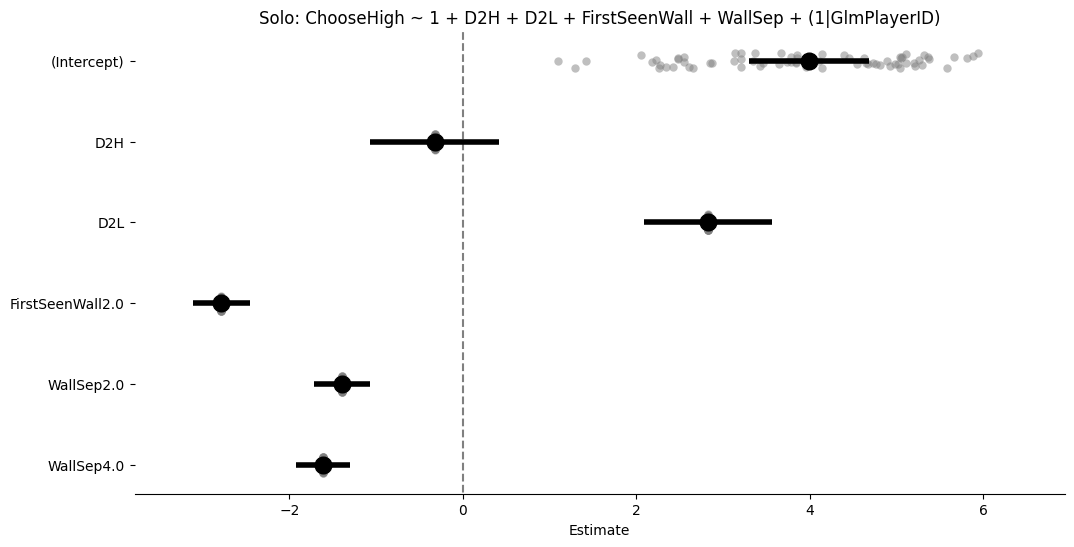

In [16]:
from pymer4.models import Lmer

model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + (1|GlmPlayerID)'
solo_random_intercepts = Lmer(model_formula, data=glm_df_solo, family='binomial')

# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + (D2L|| GlmPlayerID)'
# solo_random_intercepts_D2L_slope = Lmer(model_formula, data=glm_df_solo, family='binomial')

# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + WallSep:FirstSeenWall + D2H:FirstSeenWall + D2L:FirstSeenWall  +  (1|GlmPlayerID)'
# solo_random_intercepts_wallsep_wallseen_interaction = Lmer(model_formula, data=glm_df_solo, family='binomial')

model = Lmer(model_formula, data=glm_df_solo, family='binomial')
results=model.fit()

print(results)
ax = model.plot_summary()
ax.set_title("Solo: " + model_formula)

#### Solo-social combined model

Text(0.5, 1.0, 'Solo-Social: ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + SocialContext\n + SocialContext:D2L +  SocialContext:D2H + SocialContext:FirstSeenWall + (1 |GlmPlayerID)')

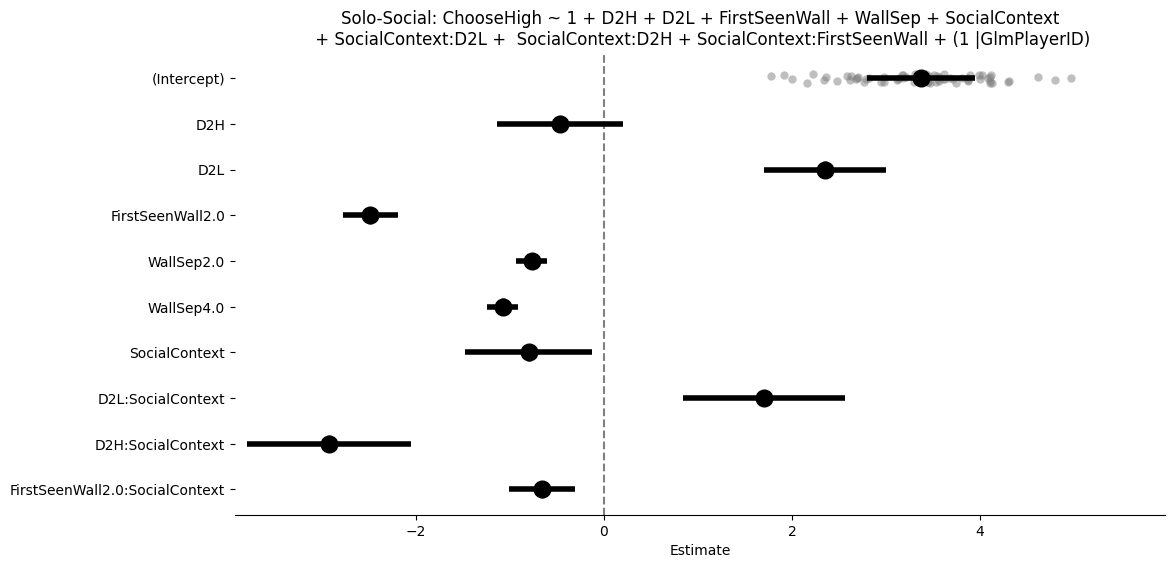

In [19]:
ax = model.plot_summary()
ax.set_title("Solo-Social: " + 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + SocialContext\n + SocialContext:D2L +  SocialContext:D2H + SocialContext:FirstSeenWall + (1 |GlmPlayerID)')

d:\Users\Tom\miniconda3\envs\octagon_analysis\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "WallSep". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


Model failed to converge with max|grad| = 0.0224901 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: ChooseHigh~1+D2H+D2L+FirstSeenWall+WallSep+SocialContext+SocialContext:D2L+SocialContext:D2H+SocialContext:FirstSeenWall+(1|GlmPlayerID)

Family: binomial	 Inference: parametric

Number of observations: 12719	 Groups: {'GlmPlayerID': 74.0}

Log-likelihood: -2934.307 	 AIC: 5890.615

Random effects:

                    Name    Var    Std
GlmPlayerID  (Intercept)  0.503  0.709

No random effect correlations specified

Fixed effects:

                                Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci 

d:\Users\Tom\miniconda3\envs\octagon_analysis\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


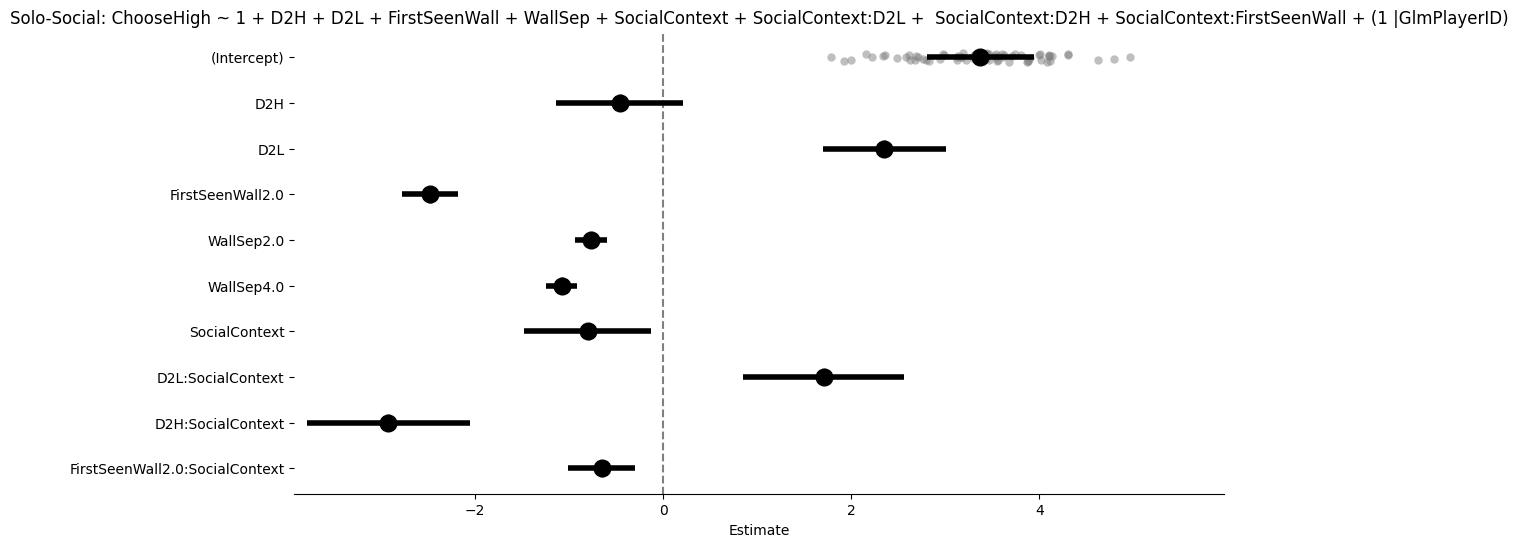

In [18]:
from pymer4.models import Lmer

# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + SocialContext + (1 |GlmPlayerID)'
# social_solo_random_intercepts = Lmer(model_formula, data=glm_df_solo_social, family='binomial')

# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + SocialContext + (D2L|| GlmPlayerID)'
# solo_random_intercepts_D2L_slope = Lmer(model_formula, data=glm_df_solo_social, family='binomial')

model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + SocialContext + SocialContext:D2L +  SocialContext:D2H + SocialContext:FirstSeenWall + (1 |GlmPlayerID)'
social_solo_random_intercepts = Lmer(model_formula, data=glm_df_solo_social, family='binomial')

# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + WallSep:FirstSeenWall + D2H:FirstSeenWall + D2L:FirstSeenWall + (1|GlmPlayerID)'
# solo_random_intercepts_wallsep_wallseen_interaction = Lmer(model_formula, data=glm_df_solo_social, family='binomial')

model = Lmer(model_formula, data=glm_df_solo_social, family='binomial')
results=model.fit()
ax = model.plot_summary()
ax.set_title("Solo-Social: " + model_formula)

print(results)

#### Social model

Text(0.5, 1.0, 'Solo-Social: ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + OpponentD2H + OpponentD2L + OpponentFirstSeenWall + (1|GlmPlayerID)')

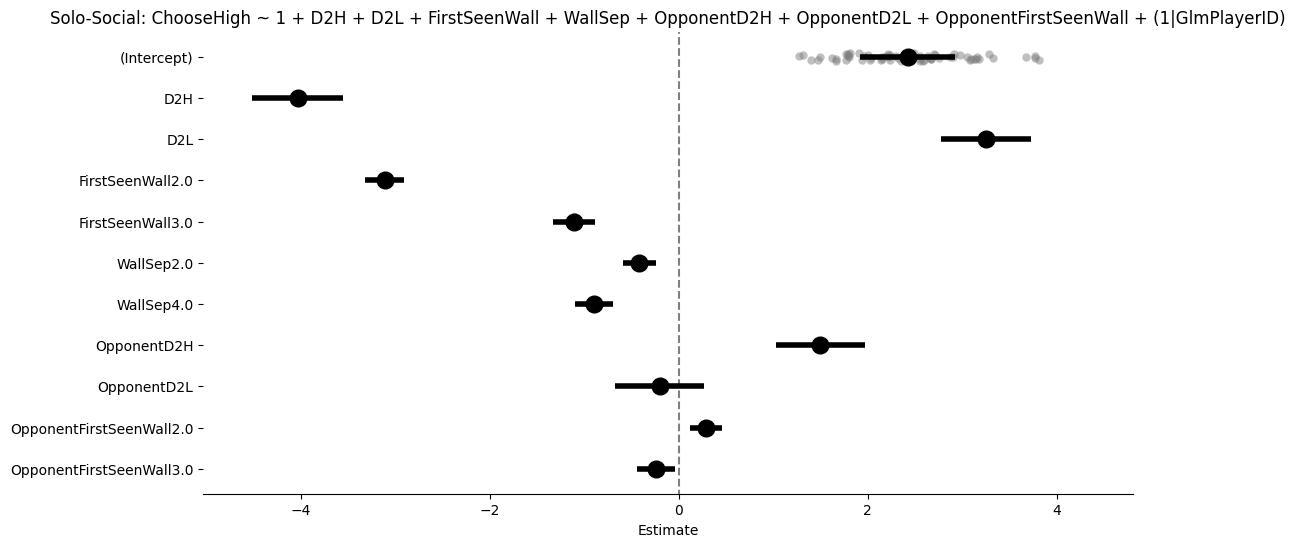

In [89]:
ax = model.plot_summary()
ax.set_title("Solo-Social: " + model_formula)

d:\Users\Tom\miniconda3\envs\octagon_analysis\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "WallSep". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
d:\Users\Tom\miniconda3\envs\octagon_analysis\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: ChooseHigh~1+D2H+D2L+FirstSeenWall+WallSep+OpponentD2H+OpponentD2L+OpponentFirstSeenWall+(1|GlmPlayerID)

Family: binomial	 Inference: parametric

Number of observations: 7772	 Groups: {'GlmPlayerID': 74.0}

Log-likelihood: -1299.674 	 AIC: 2619.348

Random effects:

                    Name    Var    Std
GlmPlayerID  (Intercept)  0.428  0.654

No random effect correlations specified

Fixed effects:

                          Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig
(Intercept)                  2.216   1.459    2.973  0.386   9.169      4.300      19.549  0.902    

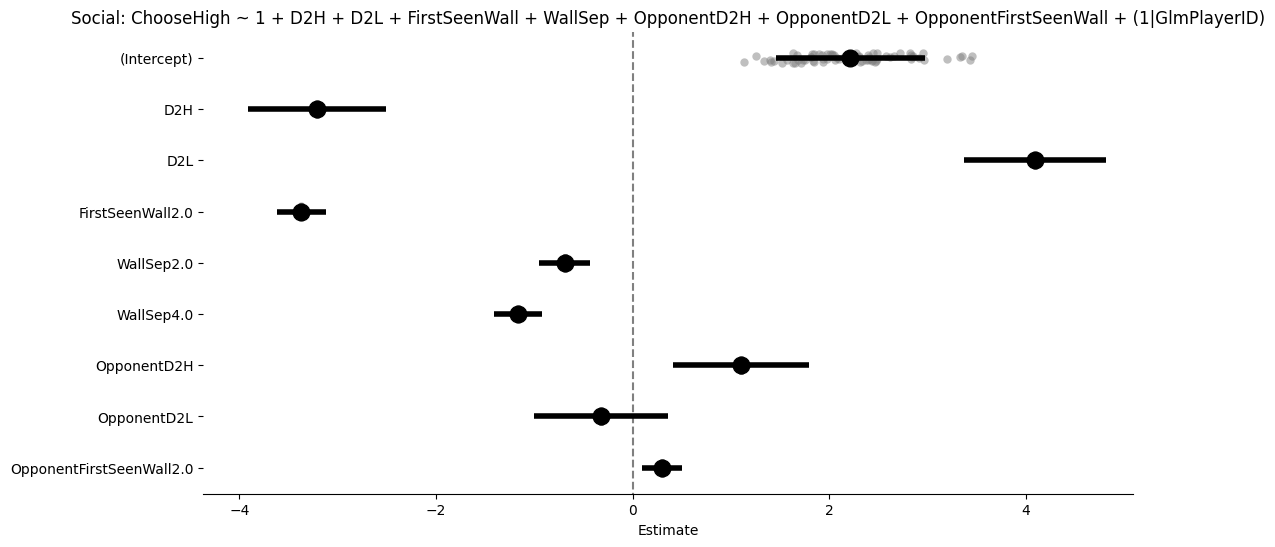

In [12]:
from pymer4.models import Lmer

# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + OpponentVisible + OpponentD2H + OpponentD2L + OpponentFirstSeenWall + (1|GlmPlayerID)'
model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + OpponentD2H + OpponentD2L + OpponentFirstSeenWall + (1|GlmPlayerID)'

# model_formula = 'ChooseHigh ~ D2H + D2L + FirstSeenWall + WallSep + OpponentD2H + OpponentD2L + OpponentFirstSeenWall + WallSep:FirstSeenWall + D2L:FirstSeenWall + (1 | GlmPlayerID)'
# model_formula = 'ChooseHigh ~ D2H + D2L + FirstSeenWall + WallSep + OpponentD2H + OpponentD2L + OpponentFirstSeenWall + WallSep:FirstSeenWall + D2L:FirstSeenWall + D2H:FirstSeenWall +  (1 | GlmPlayerID)'

# model_formula = 'ChooseHigh ~ D2H + D2L + FirstSeenWall + WallSep + OpponentVisible + OpponentD2H + OpponentD2L + OpponentFirstSeenWall + (D2H + D2L + FirstSeenWall + WallSep + OpponentVisible + OpponentD2H + OpponentD2L + OpponentFirstSeenWall| GlmPlayerID)'
# model_formula = 'ChooseHigh ~ D2H + D2L + FirstSeenWall + WallSep + OpponentVisible + OpponentD2H + OpponentD2L + (1 + D2H + D2L + FirstSeenWall + OpponentVisible + OpponentD2H + OpponentD2L || GlmPlayerID)'


model = Lmer(model_formula, data=glm_df_social, family='binomial')

results=model.fit()
ax = model.plot_summary()
ax.set_title("Social: " + model_formula)


print(results)

#### Checking colinearity

In [97]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import re

model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + OpponentVisible + OpponentD2H + OpponentD2L + OpponentFirstSeenWall + (1|GlmPlayerID)'

# begin at start (^), lazily match any character any number of times ((.*?)), lazy non-matching group for space, +, space ((?:\s+\s)?), an opening parenthesis (\()
pattern = r'^(.*?)(?:\s\+\s)?\('
match = re.match(pattern, model_formula)
formula = match.group(1)
# formula = 'ChooseHigh ~ D2L + D2H + FirstSeenWall + WallSep + OpponentVisible + OpponentD2H + OpponentD2L + OpponentFirstSeenWall' # only including fixed effects
y, X = dmatrices(formula, data=glm_df_social, return_type='dataframe')

# compute VIF (variance inflation factor)
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]


In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import re

model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + (1|GlmPlayerID)'

# begin at start (^), lazily match any character any number of times ((.*?)), lazy non-matching group for space, +, space ((?:\s+\s)?), an opening parenthesis (\()
pattern = r'^(.*?)(?:\s\+\s)?\('
match = re.match(pattern, model_formula)
formula = match.group(1)
# formula = 'ChooseHigh ~ D2L + D2H + FirstSeenWall + WallSep + OpponentVisible + OpponentD2H + OpponentD2L + OpponentFirstSeenWall' # only including fixed effects
y, X = dmatrices(formula, data=glm_df_solo, return_type='dataframe')

# compute VIF (variance inflation factor)
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]


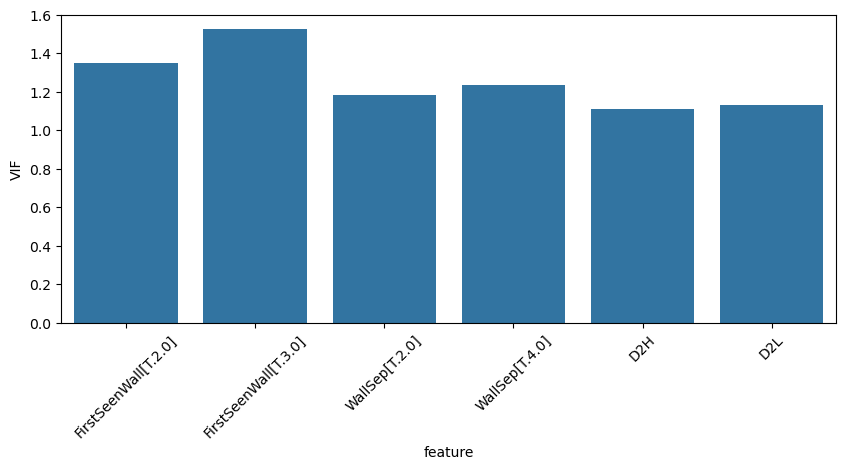

In [27]:
import seaborn as sns

plt.figure(figsize=(10,4))
sns.barplot(data=vif_data, x=vif_data['feature'].iloc[1:], y=vif_data['VIF'].iloc[1:])
plt.tick_params(axis='x', rotation=45)


In [102]:
glm_df_social[['D2L','D2H','FirstSeenWall', 'WallSep', 'OpponentVisible','OpponentD2H', 'OpponentD2L', 'OpponentFirstSeenWall']].corr()

,D2L,D2H,FirstSeenWall,WallSep,OpponentVisible,OpponentD2H,OpponentD2L,OpponentFirstSeenWall
D2L,1.000000000,0.125786195,0.283610294,0.002504460,0.072935137,0.009473124,-0.012471789,-0.017041324
D2H,0.125786195,1.000000000,0.130565134,0.001967019,0.077135199,0.014379237,0.009473124,0.011411470
FirstSeenWall,0.283610294,0.130565134,1.000000000,-0.230161519,0.118595710,0.011411470,-0.017041324,0.056880885
WallSep,0.002504460,0.001967019,-0.230161519,1.000000000,-0.006156287,0.001967019,0.002504460,-0.230161519
OpponentVisible,0.072935137,0.077135199,0.118595710,-0.006156287,1.000000000,-0.000620275,-0.006471035,0.022570096
OpponentD2H,0.009473124,0.014379237,0.011411470,0.001967019,-0.000620275,1.000000000,0.125786195,0.130565134
OpponentD2L,-0.012471789,0.009473124,-0.017041324,0.002504460,-0.006471035,0.125786195,1.000000000,0.283610294
OpponentFirstSeenWall,-0.017041324,0.011411470,0.056880885,-0.230161519,0.022570096,0.130565134,0.283610294,1.000000000


#### Plotting random slopes

In [103]:
model.coefs

,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),2.423293404,1.922786115,2.923800693,0.255365554,11.282957529,6.839988942,18.611891288,0.918586383,0.872448800,0.949010527,9.489507745,2.321278274e-21,***
D2H,-4.036641821,-4.518796567,-3.554487075,0.246001840,0.017656667,0.010902136,0.028596039,0.017350318,0.010784561,0.027801039,-16.408990384,1.649252329e-60,***
D2L,3.252617001,2.778146579,3.727087423,0.242081194,25.857921660,16.089173284,41.557891182,0.962767037,0.941483419,0.976502595,13.436058138,3.717166534e-41,***
FirstSeenWall2.0,-3.115027861,-3.320767148,-2.909288575,0.104970953,0.044377271,0.036125108,0.054514499,0.042491609,0.034865585,0.051696301,-29.675141420,1.607500329e-193,***
FirstSeenWall3.0,-1.109241144,-1.333406298,-0.885075989,0.114372079,0.329809144,0.263577905,0.412682813,0.248012390,0.208596482,0.292127015,-9.698530945,3.058707533e-22,***
WallSep2.0,-0.417862688,-0.594967292,-0.240758084,0.090361152,0.658452636,0.551580607,0.786031757,0.397028303,0.355495940,0.440099541,-4.624362113,3.757529416e-06,***
WallSep4.0,-0.896581196,-1.096089512,-0.697072880,0.101791828,0.407962021,0.334175321,0.498040998,0.289753569,0.250473319,0.332461527,-8.807987999,1.274120729e-18,***
OpponentD2H,1.496061986,1.026229267,1.965894705,0.239714976,4.464074820,2.790523651,7.141299088,0.816986401,0.736184208,0.877169480,6.241003428,4.347727184e-10,***
OpponentD2L,-0.201941114,-0.671361324,0.267479096,0.239504508,0.817143045,0.511012451,1.306666314,0.449685591,0.338192085,0.566473922,-0.843162060,3.991378143e-01,
OpponentFirstSeenWall2.0,0.288361743,0.115001086,0.461722400,0.088450940,1.334239869,1.121874656,1.586804744,0.571595013,0.528718628,0.613422698,3.260132035,1.113603599e-03,**


In [104]:
model.coefs.loc['D2H', 'Estimate']

np.float64(-4.0366418207721475)

In [105]:
model.fixef.iloc[0]

(Intercept)                 2.188905583
D2H                        -4.036641821
D2L                         3.252617001
FirstSeenWall2.0           -3.115027861
FirstSeenWall3.0           -1.109241144
WallSep2.0                 -0.417862688
WallSep4.0                 -0.896581196
OpponentD2H                 1.496061986
OpponentD2L                -0.201941114
OpponentFirstSeenWall2.0    0.288361743
OpponentFirstSeenWall3.0   -0.239951405
Name: 0, dtype: float64

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming ranefs is your wide-format DataFrame
re_df = model.ranef.copy()

# Optional: Add participant IDs as a proper column if they're in the index
re_df['GlmPlayerID'] = re_df.index

# Define slopes to plot and extract fixed effects
slope_vars = ['FirstSeenWall2.0', 'D2H', 'D2L']
fixed_effects_coefs = model.coefs  # Returns a DataFrame with Estimate per predictor


# Plot
fig, axs = plt.subplots(len(slope_vars), 1, figsize=(14,12), sharex=False)
for i, slope in enumerate(slope_vars):
    
    if len(slope_vars) == 1:
        ax = axs
    else:    
        ax = axs[i]

    # Sort by slope for ordered bars
    sorted_df = re_df.sort_values(slope)

    # plot bars
    sns.barplot(data=sorted_df, x='GlmPlayerID', y=slope, ax=ax, palette='coolwarm')
    ax.set_title(f"Random slope values for {slope} across players")
    ax.set_xlabel("Participant ID")
    ax.set_ylabel("Deviation from fixed effect value")

    # Rotate x-axis ticks for readability
    ax.tick_params(axis='x', rotation=90)

    # Annotate with fixed effect value
    fixed_val = fixed_effects_coefs.loc[slope, 'Estimate']
    ax.text(0.01, 0.9, f'Fixed effect = {fixed_val:.3f}', transform=ax.transAxes,
            fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))


plt.tight_layout()
plt.show

In [107]:
model.coefs['Estimate']

(Intercept)                 2.423293404
D2H                        -4.036641821
D2L                         3.252617001
FirstSeenWall2.0           -3.115027861
FirstSeenWall3.0           -1.109241144
WallSep2.0                 -0.417862688
WallSep4.0                 -0.896581196
OpponentD2H                 1.496061986
OpponentD2L                -0.201941114
OpponentFirstSeenWall2.0    0.288361743
OpponentFirstSeenWall3.0   -0.239951405
Name: Estimate, dtype: float64

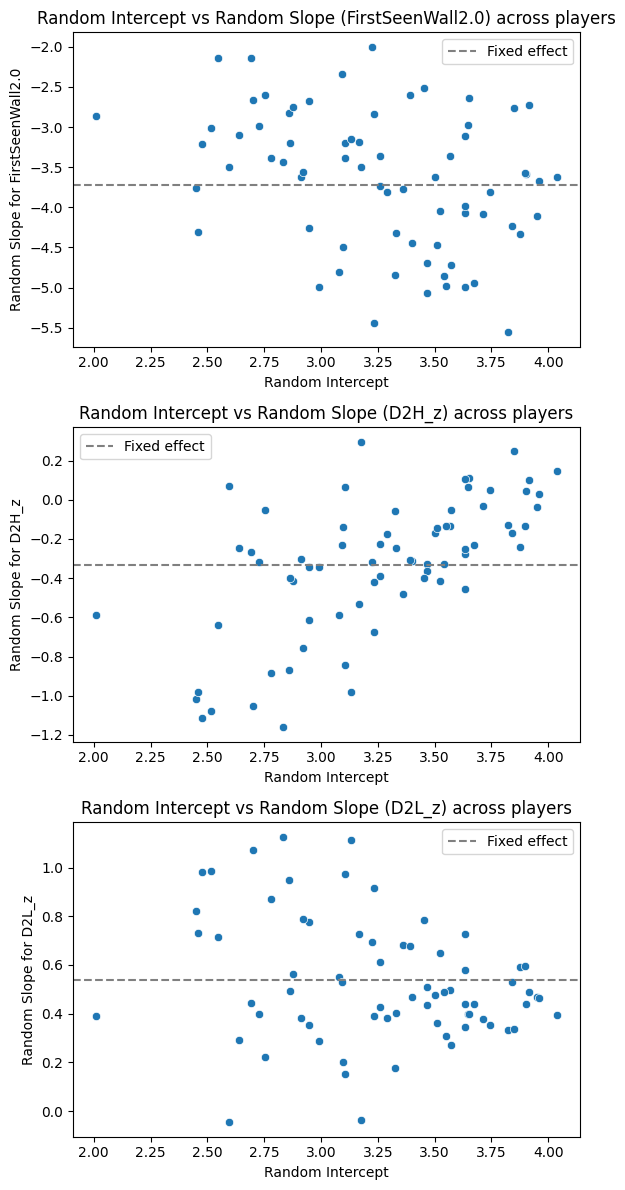

In [ ]:
# Assuming ranefs is your wide-format DataFrame
re_df = model.ranef.copy()
# Optional: Add participant IDs as a proper column if they're in the index
re_df['GlmPlayerID'] = re_df.index

slope_vars = ['FirstSeenWall2.0', 'D2H_z', 'D2L_z']
fixed_effects_coefs = model.coefs  # Returns a DataFrame with Estimate per predictor
fixed_intercept = model.coefs.loc['(Intercept)', 'Estimate']

# plot
fig, axs = plt.subplots(len(slope_vars),1, figsize=(6,12), sharex=False)
for i, slope in enumerate(slope_vars):
    if len(slope_vars) == 1:
        ax = axs
    else:    
        ax = axs[i]

    # sort by slope for ordered bars
    random_slopes = re_df[slope] + fixed_effects_coefs.loc[slope, 'Estimate']
    random_intercepts = re_df['X.Intercept.'] + fixed_intercept

    # Scatter plot
    sns.scatterplot(x=random_intercepts, y=random_slopes, ax=ax)
    ax.set_title(f"Random Intercept vs Random Slope ({slope}) across players")
    ax.set_xlabel("Random Intercept")
    ax.set_ylabel(f"Random Slope for {slope}")

    # Add a horizontal line for the fixed effect
    ax.axhline(fixed_effects_coefs.loc[slope, 'Estimate'], color='gray', linestyle='--', label='Fixed effect')
    ax.legend()



plt.tight_layout()
plt.legend()
plt.show()

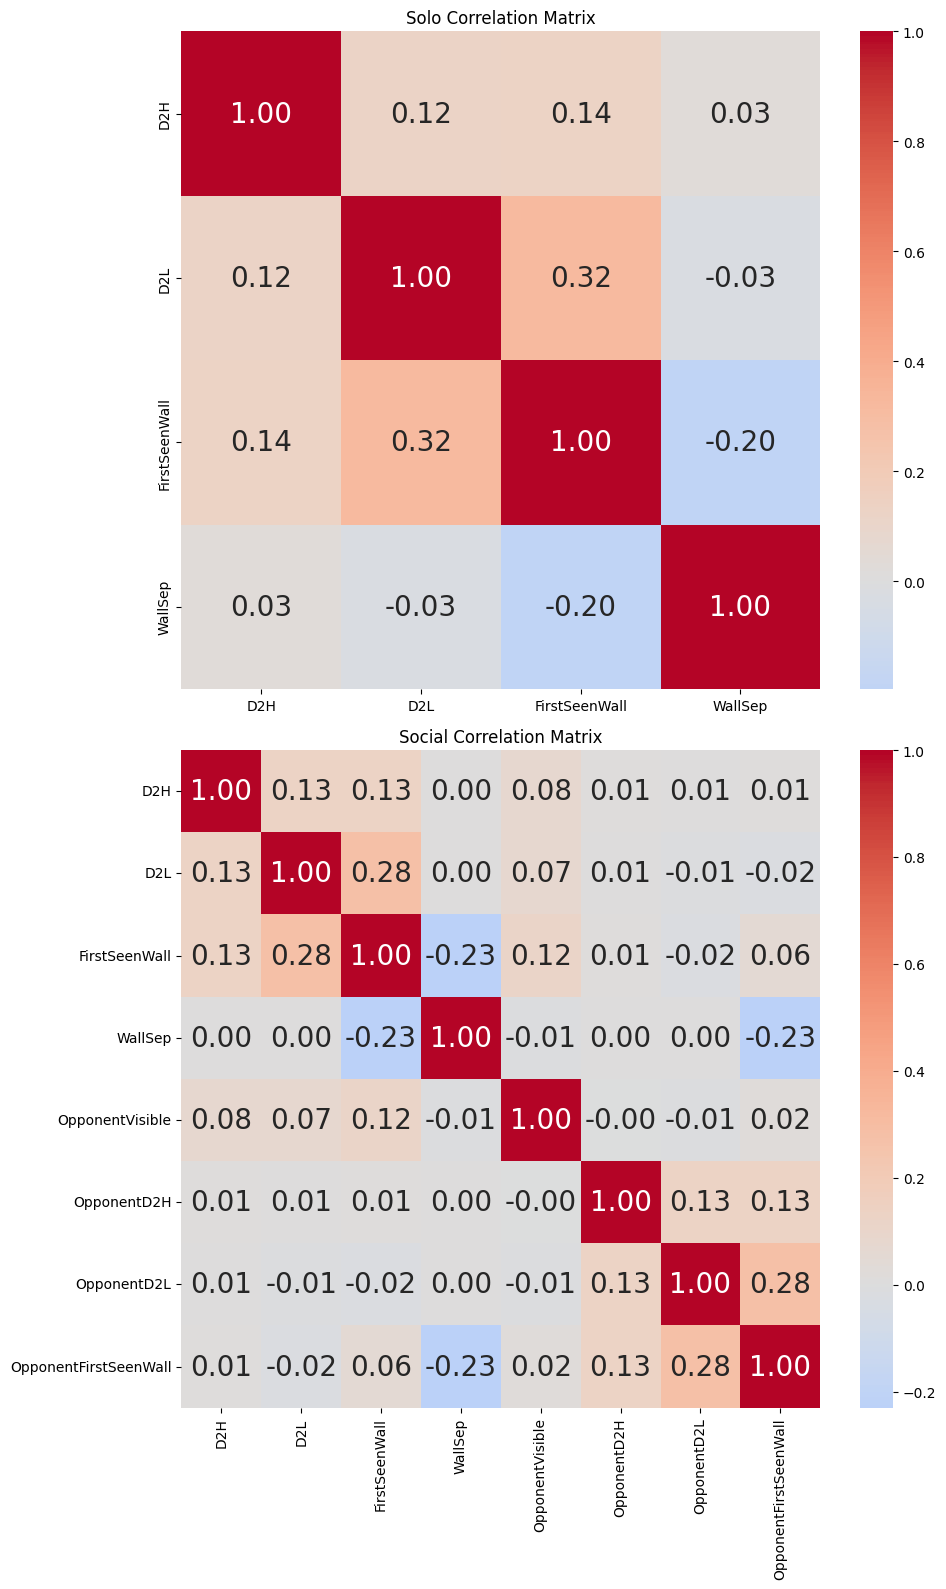

In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# predictors
social_predictors = ['D2H', 'D2L', 'FirstSeenWall', 'WallSep', 'OpponentVisible', 'OpponentD2H', 'OpponentD2L', 'OpponentFirstSeenWall']
solo_predictors = ['D2H', 'D2L', 'FirstSeenWall', 'WallSep']

# Compute correlation matrix
corr_matrix_solo = glm_df_solo[solo_predictors].corr()
corr_matrix_social = glm_df_social[social_predictors].corr()

# Plot it
plt.subplots(2,1, figsize=(10, 16))
plt.subplot(2,1,1)
sns.heatmap(corr_matrix_solo, annot=True, fmt=".2f", cmap="coolwarm", center=0, annot_kws={"size": 20})
plt.title("Solo Correlation Matrix")
plt.subplot(2,1,2)
sns.heatmap(corr_matrix_social, annot=True, fmt=".2f", cmap="coolwarm", center=0, annot_kws={"size": 20})
plt.title("Social Correlation Matrix")
plt.tight_layout()
plt.show()

d:\Users\Tom\miniconda3\envs\octagon_analysis\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "WallSep". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
d:\Users\Tom\miniconda3\envs\octagon_analysis\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "FirstSeenWall". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
d:\Users\Tom\miniconda3\envs\octagon_analysis\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
d:\Users\Tom\miniconda3\envs\octagon_analysis\Lib\site-packages\rpy2\robjects\pandas2ri.py:

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: ChooseHigh~1+D2H+D2L+FirstSeenWall+WallSep+(1|GlmPlayerID)

Family: binomial	 Inference: parametric

Number of observations: 4605	 Groups: {'GlmPlayerID': 70.0}

Log-likelihood: -1144.956 	 AIC: 2305.912

Random effects:

                    Name   Var    Std
GlmPlayerID  (Intercept)  1.95  1.397

No random effect correlations specified

Fixed effects:



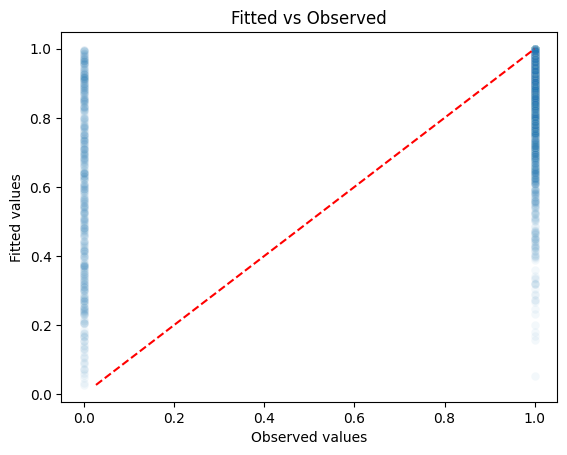

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

solo_random_intercepts.fit()

# Assuming `model` is your fitted pymer4 model
df = solo_random_intercepts.data.copy()
df = df.dropna() # remove rows with NaN values because these cannot be predicted

df['fitted'] = solo_random_intercepts.predict(df, skip_data_checks=True, verify_predictions=False)

sns.scatterplot(x='ChooseHigh', y='fitted', data=df, alpha=0.05)
plt.plot([df['fitted'].min(), df['fitted'].max()],
         [df['fitted'].min(), df['fitted'].max()], 'r--')
plt.xlabel('Observed values')
plt.ylabel('Fitted values')
plt.title('Fitted vs Observed')
plt.show()

In [ ]:
glm_df_social.to_csv("glm_df_social.csv", index=False)
